In [ ]:
# This is an example snippet!
# To create your own, add a new snippet block to the
# snippets.json file in your jupyter nbextensions directory:
# /nbextensions/snippets/snippets.json
import this

In [1]:
import pandas as pd
import random
import itertools

Downloaded data from: http://web.mta.info/developers/turnstile.html

Documentations at: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

Map of the MTA system: http://web.mta.info/maps/submap.html

In [2]:
df = pd.read_csv('turnstile_May26.txt')

In [3]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,00:00:00,REGULAR,6625470,2245312
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,04:00:00,REGULAR,6625494,2245314
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,08:00:00,REGULAR,6625514,2245338
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,12:00:00,REGULAR,6625595,2245415
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,16:00:00,REGULAR,6625791,2245481


Fix 'EXITS' column name (it has many spaces at the end of it)

In [4]:
# old_exit_name = df.columns[-1]
df.rename(columns={df.columns[-1]: 'EXITS'}, inplace = True)

In [5]:
backup_df = df.copy()

In [4]:
# df.DATE = pd.to_datetime(df.DATE)

In [6]:
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)

In [7]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,00:00:00,REGULAR,6625470,2245312,2018-05-19 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,04:00:00,REGULAR,6625494,2245314,2018-05-19 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,08:00:00,REGULAR,6625514,2245338,2018-05-19 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,12:00:00,REGULAR,6625595,2245415,2018-05-19 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/19/2018,16:00:00,REGULAR,6625791,2245481,2018-05-19 16:00:00


Make list of columns which we'll use at the key (i.e. the first 4) and a list of the rest.

In [8]:
key_cols = list(df.columns[:4])
key_cols

['C/A', 'UNIT', 'SCP', 'STATION']

In [9]:
other_cols = list(df.columns[4:])
other_cols

['LINENAME',
 'DIVISION',
 'DATE',
 'TIME',
 'DESC',
 'ENTRIES',
 'EXITS',
 'DATETIME']

Create dictionary, using 4-column key:

In [23]:
dct = df.groupby(key_cols)[other_cols].apply(lambda x: list(x.values)).to_dict()

In [37]:
grp1 = df.groupby(key_cols + ['DATE'])['ENTRIES'].sum().reset_index()
grp2 = df.groupby(key_cols + ['DATETIME'])['ENTRIES'].sum().reset_index()

In [38]:
grp1.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,05/19/2018,39753882
1,A002,R051,02-00-00,59 ST,05/20/2018,39757638
2,A002,R051,02-00-00,59 ST,05/21/2018,39761889
3,A002,R051,02-00-00,59 ST,05/22/2018,39770555
4,A002,R051,02-00-00,59 ST,05/23/2018,39779286


In [33]:
dct = df.groupby(key_cols).apply(lambda x: list(x.values)).to_dict()

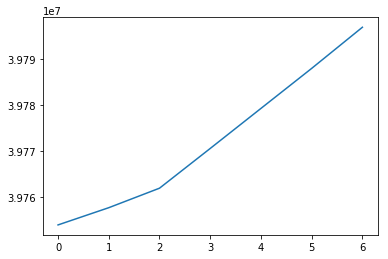

In [36]:
data = grp1[:7].values
plt.plot(data)

In [12]:
# df_grp = df.groupby(key_cols)[other_cols].apply(lambda x: list(x.values))

In [20]:
def dict_glance(d, n):
    '''Generates "glance" of n items (key: value pairs) of dictionary d.
    If value is list, returns each item of list on new line'''
    for i in range(n):
        rand_key = random.choice(list(d.keys()))
        print (rand_key)
        print('\n'.join('%s' % v for v in d[rand_key]))

In [25]:
def dict_rand(d):
    '''Generates a list of a random (key: value pairs) of dictionary d.'''
    rand_key = random.choice(list(d.keys()))
    print (rand_key)
#     print('\n'.join('%s' % v for v in d[rand_key]))
    return [rand_key, d[rand_key]]

In [11]:
dict_glance(dct, 2)

('R118', 'R343', '01-00-02', 'FRANKLIN ST')
['1' 'IRT' '05/19/2018' '01:00:00' 'REGULAR' 402389 757439]
['1' 'IRT' '05/19/2018' '05:00:00' 'REGULAR' 402390 757442]
['1' 'IRT' '05/19/2018' '09:00:00' 'REGULAR' 402393 757482]
['1' 'IRT' '05/19/2018' '13:00:00' 'REGULAR' 402410 757558]
['1' 'IRT' '05/19/2018' '17:00:00' 'REGULAR' 402430 757614]
['1' 'IRT' '05/19/2018' '21:00:00' 'REGULAR' 402445 757670]
['1' 'IRT' '05/20/2018' '01:00:00' 'REGULAR' 402459 757692]
['1' 'IRT' '05/20/2018' '05:00:00' 'REGULAR' 402460 757693]
['1' 'IRT' '05/20/2018' '09:00:00' 'REGULAR' 402462 757719]
['1' 'IRT' '05/20/2018' '13:00:00' 'REGULAR' 402479 757802]
['1' 'IRT' '05/20/2018' '17:00:00' 'REGULAR' 402509 757875]
['1' 'IRT' '05/20/2018' '21:00:00' 'REGULAR' 402531 757921]
['1' 'IRT' '05/21/2018' '01:00:00' 'REGULAR' 402534 757930]
['1' 'IRT' '05/21/2018' '05:00:00' 'REGULAR' 402534 757932]
['1' 'IRT' '05/21/2018' '09:00:00' 'REGULAR' 402566 758057]
['1' 'IRT' '05/21/2018' '13:00:00' 'REGULAR' 402607 7581

In [26]:
dum = dict_rand(dct)

('J020', 'R433', '00-00-00', 'ALABAMA AV')


In [30]:
dum[1][1]

array(['J', 'BMT', '05/19/2018', '05:00:00', 'REGULAR', 1948607, 1589550,
       Timestamp('2018-05-19 05:00:00')], dtype=object)

In [26]:
rand_key = random.choice(list(dct.keys()))
data = dct[rand_key]
data

[array(['6', 'IRT', '05/19/2018', '00:00:00', 'REGULAR', 3087368, 3655713,
        Timestamp('2018-05-19 00:00:00')], dtype=object),
 array(['6', 'IRT', '05/19/2018', '04:00:00', 'REGULAR', 3087373, 3655731,
        Timestamp('2018-05-19 04:00:00')], dtype=object),
 array(['6', 'IRT', '05/19/2018', '08:00:00', 'REGULAR', 3087400, 3655755,
        Timestamp('2018-05-19 08:00:00')], dtype=object),
 array(['6', 'IRT', '05/19/2018', '12:00:00', 'REGULAR', 3087434, 3655826,
        Timestamp('2018-05-19 12:00:00')], dtype=object),
 array(['6', 'IRT', '05/19/2018', '16:00:00', 'REGULAR', 3087474, 3655891,
        Timestamp('2018-05-19 16:00:00')], dtype=object),
 array(['6', 'IRT', '05/19/2018', '20:00:00', 'REGULAR', 3087503, 3655995,
        Timestamp('2018-05-19 20:00:00')], dtype=object),
 array(['6', 'IRT', '05/20/2018', '00:00:00', 'REGULAR', 3087530, 3656035,
        Timestamp('2018-05-20 00:00:00')], dtype=object),
 array(['6', 'IRT', '05/20/2018', '04:00:00', 'REGULAR', 3087534, 365

In [27]:
data[1]

array(['6', 'IRT', '05/19/2018', '04:00:00', 'REGULAR', 3087373, 3655731,
       Timestamp('2018-05-19 04:00:00')], dtype=object)

In [ ]:
aa

In [ ]:
plt.plota


### To Do Next:

Check for null or '0' entries in Entrance & Exit. (See above entries for ('R523', 'R147', '00-05-00', '61 ST WOODSIDE') key -- all entrances are 3429 +/- 1, and all Exits are 0. 

Is there a way to get list of defunct stations?
Or do, we not care -- will just ignore / exlude these stations from consideration.

Create new column of date-time

In [ ]:
df